In [3]:
# importing pre-requisite libraries
import os
import sys

In [4]:
# Get the absolute path of the credit_risk package
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
print(project_root)

c:\Aravind's File\Projects\Sales-Prediction


In [5]:
#importing the modules from the package
from utils.utils import *
from utils.preprocessing.preprocess import *

In [6]:
config_ = load_config()
config_

{'data': {'path': "C:/Aravind's File/Projects/Sales-Prediction/data/",
  'sales_data': 'Walmart.csv',
  'preprocessed_data': 'preprocessed_data.parquet',
  'feature_engineered_data': 'feature_engineered_data.parquet',
  'model_input_data': 'model_input_data.parquet'}}

In [7]:
data_path_list = return_config_params('data')
data_path_list

{'path': "C:/Aravind's File/Projects/Sales-Prediction/data/",
 'sales_data': 'Walmart.csv',
 'preprocessed_data': 'preprocessed_data.parquet',
 'feature_engineered_data': 'feature_engineered_data.parquet',
 'model_input_data': 'model_input_data.parquet'}

In [8]:
# Load the data
sales_data = pd.read_csv(os.path.join(data_path_list['path'], data_path_list['sales_data']))
sales_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Preprocessing

## 1. Data type detection and conversion

In [9]:
sales_data_2 = create_date_variables(sales_data, 'Date')
sales_data_2.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,12
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5


In [10]:
# check numerical and categorical variables and automatically convert them to the right type
def check_data_types(df):
    # Get the data types of all columns
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    date_features = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

    # Check for features that might be misclassified (e.g., numerical IDs stored as objects)
    for col in df.columns:
        if col not in date_features:
            unique_values = df[col].nunique()
            if unique_values < 100:  # Arbitrary threshold for categorical-like behavior
                print(f"Feature '{col}' has {unique_values} unique values and might be categorical.")
                numerical_features.remove(col) if col in numerical_features else None
                categorical_features.append(col) if col not in categorical_features else None
            else:
                print(f"Feature '{col}' is likely numerical with {unique_values} unique values.")

    print(f"Numerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")
    print(f"Date features: {date_features}")

    return df, numerical_features, categorical_features, date_features
sales_data_3, numerical_features, categorical_features, date_features = check_data_types(sales_data_2)

Feature 'Store' has 45 unique values and might be categorical.
Feature 'Weekly_Sales' is likely numerical with 6435 unique values.
Feature 'Holiday_Flag' has 2 unique values and might be categorical.
Feature 'Temperature' is likely numerical with 3528 unique values.
Feature 'Fuel_Price' is likely numerical with 892 unique values.
Feature 'CPI' is likely numerical with 2145 unique values.
Feature 'Unemployment' is likely numerical with 349 unique values.
Feature 'year' has 3 unique values and might be categorical.
Feature 'month' has 12 unique values and might be categorical.
Feature 'day' has 31 unique values and might be categorical.
Numerical features: ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Categorical features: ['Store', 'Holiday_Flag', 'year', 'month', 'day']
Date features: ['Date']


In [11]:
# converting the variables to the right type as per the check_data_types function
def convert_data_types(df, numerical_features, categorical_features):
    # Convert categorical features to 'category' type
    for col in categorical_features:
        df[col] = df[col].astype('category')

    # Convert numerical features to 'float64' type
    for col in numerical_features:
        df[col] = df[col].astype('float64')

    return df

sales_data_4 = convert_data_types(sales_data_3, numerical_features, categorical_features)
sales_data_4.dtypes

Store                 category
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag          category
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
year                  category
month                 category
day                   category
dtype: object

In [12]:
for i in ['day', 'month']:
    sales_data_4[i] = sales_data_4[i].astype('float64')

## 2. Outlier treatment

In [13]:
# removing outliers from the data
def remove_outliers(df, numerical_features):
    for col in numerical_features:
        # Calculate the IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df
sales_data_5 = remove_outliers(sales_data_4, numerical_features)
sales_data_5.describe()

,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,month,day
count,5917,5.917000e+03,5917.000000,5917.000000,5917.000000,5917.000000,5917.000000,5917.000000
mean,2011-06-14 17:15:31.485550080,1.039313e+06,60.433407,3.340543,175.023148,7.722305,6.444989,15.645935
min,2010-02-05 00:00:00,2.099862e+05,7.460000,2.472000,126.064000,4.308000,1.000000,1.000000
25%,2010-10-08 00:00:00,5.525292e+05,46.980000,2.891000,132.767067,6.891000,4.000000,8.000000
50%,2011-06-10 00:00:00,9.472292e+05,62.620000,3.420000,190.006988,7.852000,6.000000,16.000000
75%,2012-02-17 00:00:00,1.427624e+06,74.730000,3.721000,213.799099,8.494000,9.000000,23.000000
max,2012-10-26 00:00:00,2.685352e+06,100.140000,4.468000,227.232807,10.926000,12.000000,31.000000
std,NaN,5.519450e+05,18.386455,0.458200,39.023139,1.243337,3.220417,8.761115


1. Before Outliers we had 6435 samples and after removing outliers considering all numerical features we have 5917 samples

# Feature Engineering 

## 1. CPI Binning
We are binning the CPI column since it had two clusters type of data

In [14]:
# sales_data_5['CPI_Binned'] = pd.qcut(sales_data_5['CPI'], q=4, labels=False)
# sales_data_5['CPI_Binned'] = sales_data_5['CPI_Binned'].astype('category')
# sales_data_5['CPI_Binned'].value_counts()

In [15]:
# cpi_stats = sales_data_5.groupby('CPI_Binned')['CPI'].agg(['min', 'max']).reset_index()
# cpi_stats

## 2. Scaling the input variables

In [16]:
numerical_features.remove('Weekly_Sales')
# numerical_features.remove('CPI')

In [17]:
numerical_features

['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

In [20]:
# scaling numerical features
sales_data_5[numerical_features] = scaler.fit_transform(sales_data_5[numerical_features])
sales_data_5[numerical_features].head()

,Temperature,Fuel_Price,CPI,Unemployment
0,-0.985777,-1.677452,0.924484,0.308627
1,-1.192468,-1.729835,0.928221,0.308627
2,-1.115231,-1.804045,0.929424,0.308627
3,-0.750801,-1.701461,0.930206,0.308627
4,-0.757872,-1.561772,0.930988,0.308627


In [21]:
sales_data_5[numerical_features].describe()

,Temperature,Fuel_Price,CPI,Unemployment
count,5.917000e+03,5.917000e+03,5.917000e+03,5.917000e+03
mean,2.161529e-16,2.593835e-16,-6.724758e-17,3.458447e-16
std,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00
min,-2.881354e+00,-1.895716e+00,-1.254724e+00,-2.746314e+00
25%,-7.317639e-01,-9.811898e-01,-1.082938e+00,-6.686644e-01
50%,1.189342e-01,1.734263e-01,3.840057e-01,1.043209e-01
75%,7.776269e-01,8.304006e-01,9.937496e-01,6.207170e-01
max,2.159739e+00,2.460832e+00,1.338028e+00,2.576909e+00


In [22]:
sales_data_5.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day'],
      dtype='object')

In [23]:
import numpy as np

# Apply log transformation
sales_data_5['Weekly_Sales_Log'] = np.log1p(sales_data_5['Weekly_Sales'])  # log1p handles log(0) safely

## 3. Model Inputs

### 3.1 Input for Tree based models

In [24]:
input_for_tree_models = sales_data_5.copy()

In [25]:
input_for_tree_models.reset_index(drop=True, inplace=True)
input_for_tree_models

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,Weekly_Sales_Log
0,1,2010-02-05,1643690.90,0,-0.985777,-1.677452,0.924484,0.308627,2010,2.0,5.0,14.312455
1,1,2010-02-12,1641957.44,1,-1.192468,-1.729835,0.928221,0.308627,2010,2.0,12.0,14.311400
2,1,2010-02-19,1611968.17,0,-1.115231,-1.804045,0.929424,0.308627,2010,2.0,19.0,14.292967
3,1,2010-02-26,1409727.59,0,-0.750801,-1.701461,0.930206,0.308627,2010,2.0,26.0,14.158908
4,1,2010-03-05,1554806.68,0,-0.757872,-1.561772,0.930988,0.308627,2010,3.0,5.0,14.256862
...,...,...,...,...,...,...,...,...,...,...,...,...
5912,45,2012-09-28,713173.95,0,0.241861,1.432809,0.435430,0.773544,2012,9.0,28.0,13.477482
5913,45,2012-10-05,733455.07,0,0.242405,1.406617,0.439450,0.759870,2012,10.0,5.0,13.505523
5914,45,2012-10-12,734464.36,0,-0.324364,1.439357,0.443470,0.759870,2012,10.0,12.0,13.506898
5915,45,2012-10-19,718125.53,0,-0.215579,1.371695,0.443562,0.759870,2012,10.0,19.0,13.484401


### 3.2 Input for Linear and other models

#### One hot encoding

In [26]:
one_hot_features = ['Store', 'Holiday_Flag', 'year']
input_for_linear_models = pd.get_dummies(input_for_tree_models, columns=one_hot_features, drop_first=True)

In [27]:
# one hot encoding categorical features
input_for_linear_models.reset_index(drop=True, inplace=True)
input_for_linear_models

,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,month,day,Weekly_Sales_Log,Store_2,...,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Holiday_Flag_1,year_2011,year_2012
0,2010-02-05,1643690.90,-0.985777,-1.677452,0.924484,0.308627,2.0,5.0,14.312455,False,...,False,False,False,False,False,False,False,False,False,False
1,2010-02-12,1641957.44,-1.192468,-1.729835,0.928221,0.308627,2.0,12.0,14.311400,False,...,False,False,False,False,False,False,False,True,False,False
2,2010-02-19,1611968.17,-1.115231,-1.804045,0.929424,0.308627,2.0,19.0,14.292967,False,...,False,False,False,False,False,False,False,False,False,False
3,2010-02-26,1409727.59,-0.750801,-1.701461,0.930206,0.308627,2.0,26.0,14.158908,False,...,False,False,False,False,False,False,False,False,False,False
4,2010-03-05,1554806.68,-0.757872,-1.561772,0.930988,0.308627,3.0,5.0,14.256862,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5912,2012-09-28,713173.95,0.241861,1.432809,0.435430,0.773544,9.0,28.0,13.477482,False,...,False,False,False,False,False,False,True,False,False,True
5913,2012-10-05,733455.07,0.242405,1.406617,0.439450,0.759870,10.0,5.0,13.505523,False,...,False,False,False,False,False,False,True,False,False,True
5914,2012-10-12,734464.36,-0.324364,1.439357,0.443470,0.759870,10.0,12.0,13.506898,False,...,False,False,False,False,False,False,True,False,False,True
5915,2012-10-19,718125.53,-0.215579,1.371695,0.443562,0.759870,10.0,19.0,13.484401,False,...,False,False,False,False,False,False,True,False,False,True


# 4. Feature Selection 

1. Using RFE

In [28]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X = input_for_linear_models.drop(columns=['Weekly_Sales', 'Weekly_Sales_Log', 'Date'])
y = input_for_linear_models['Weekly_Sales_Log']

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model, n_features_to_select=50)
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
selected_features

Index(['Temperature', 'CPI', 'Unemployment', 'Store_2', 'Store_3', 'Store_4',
       'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10',
       'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16',
       'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22',
       'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28',
       'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
       'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_40',
       'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Holiday_Flag_1', 'year_2011', 'year_2012'],
      dtype='object')

2. Using Tree based models

In [30]:
X = input_for_tree_models.drop(columns=['Weekly_Sales', 'Weekly_Sales_Log', 'Date'])
y = input_for_tree_models['Weekly_Sales_Log']

In [31]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False)

Store           0.677106
CPI             0.199799
Unemployment    0.080924
month           0.011930
Temperature     0.009994
Fuel_Price      0.008974
day             0.007497
year            0.002635
Holiday_Flag    0.001141
dtype: float64

Both methods indicate that store is an important feature for sales which makes sense

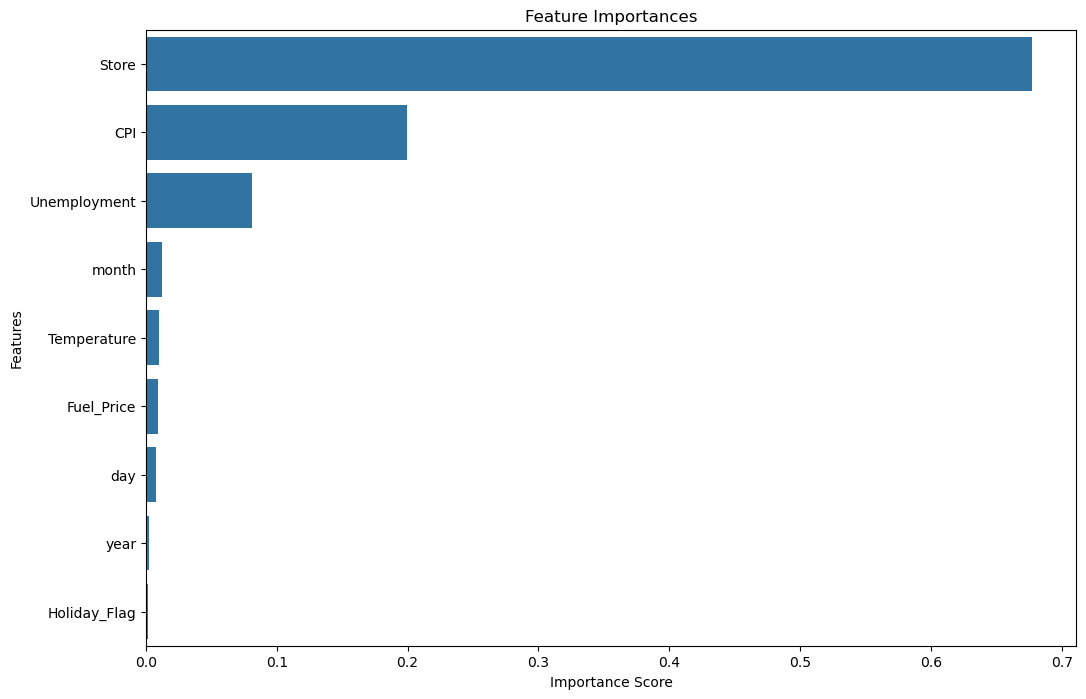

In [32]:
# plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.sort_values(ascending=False), y=feature_importance.sort_values(ascending=False).index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 5. Modelling

### 5.1 linear models

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [34]:
input_for_linear_models.columns

Index(['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'month', 'day', 'Weekly_Sales_Log', 'Store_2',
       'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8',
       'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14',
       'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20',
       'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26',
       'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32',
       'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38',
       'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44',
       'Store_45', 'Holiday_Flag_1', 'year_2011', 'year_2012'],
      dtype='object')

In [35]:
X = input_for_linear_models.drop(columns=['Weekly_Sales', 'Weekly_Sales_Log', 'Date'])  # drop target columns
y = input_for_linear_models['Weekly_Sales_Log']  # using log-transformed target

In [36]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "DecisionTree": DecisionTreeRegressor(max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=100),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(n_estimators=100, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor()
}
model_names = list(models.keys())
model_names

['LinearRegression',
 'Ridge',
 'Lasso',
 'ElasticNet',
 'DecisionTree',
 'RandomForest',
 'GradientBoosting',
 'SVR',
 'XGBoost',
 'LightGBM']

In [38]:
results = []
# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    # Fit the model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_train = model.predict(X_train)
    # Inverse transform predictions (back from log scale)
    preds_actual = np.expm1(preds)
    y_test_actual = np.expm1(y_test)

    preds_train_actual = np.expm1(preds_train)
    y_train_actual = np.expm1(y_train)
    # Evaluation metrics
    mae = mean_absolute_error(y_test_actual, preds_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, preds_actual))
    r2 = r2_score(y_test_actual, preds_actual)

    # Evaluation metrics for train set
    mae_train = mean_absolute_error(y_train_actual, preds_train_actual)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, preds_train_actual))
    r2_train = r2_score(y_train_actual, preds_train_actual)
    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAE Train': round(mae_train, 2),
        'RMSE Train': round(rmse_train, 2),
        'R2 Score Train': round(r2_train, 4),
        'R2 Score Test': round(r2, 4)
    })

Training LinearRegression...
Training Ridge...
Training Lasso...
Training ElasticNet...
Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training SVR...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 50
[LightGBM] [Info] Start training from score 13.694890


In [39]:
# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score Test', ascending=False)
print(results_df)

              Model        MAE       RMSE  MAE Train  RMSE Train  \
8           XGBoost   50755.60   83581.91   28059.20    47943.78   
9          LightGBM   51728.59   88069.92   40195.35    66751.27   
5      RandomForest   55171.10  103183.48   19567.02    37711.84   
0  LinearRegression   81273.62  136754.98   78098.58   127375.76   
1             Ridge   83050.17  138651.11   79350.14   129557.71   
3        ElasticNet   95499.58  156265.32   89034.46   144217.54   
2             Lasso   98929.25  159979.67   91928.61   146758.50   
6  GradientBoosting  197889.37  266250.22  189071.56   247536.39   
7               SVR  232628.63  326505.95  223064.81   309428.36   
4      DecisionTree  391976.39  509727.17  384223.65   494964.88   

   R2 Score Train  R2 Score Test  
8          0.9924         0.9780  
9          0.9852         0.9755  
5          0.9953         0.9664  
0          0.9462         0.9410  
1          0.9443         0.9394  
3          0.9310         0.9230  
2     

## 5.2 Tree models without one-hot encoded features

In [40]:
input_for_tree_models.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day',
       'Weekly_Sales_Log'],
      dtype='object')

In [41]:
input_for_tree_models['Store'] = input_for_tree_models['Store'].astype('int')
input_for_tree_models['year'] = input_for_tree_models['year'].astype('int')
input_for_tree_models['Holiday_Flag'] = input_for_tree_models['Holiday_Flag'].astype('int')

In [42]:
input_for_tree_models.dtypes

Store                        int64
Date                datetime64[ns]
Weekly_Sales               float64
Holiday_Flag                 int64
Temperature                float64
Fuel_Price                 float64
CPI                        float64
Unemployment               float64
year                         int64
month                      float64
day                        float64
Weekly_Sales_Log           float64
dtype: object

In [43]:
X = input_for_tree_models.drop(columns=['Weekly_Sales', 'Weekly_Sales_Log', 'Date'])  # drop target columns
y = input_for_tree_models['Weekly_Sales_Log']  # using log-transformed target

In [44]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
models_2 = {
    "DecisionTree": DecisionTreeRegressor(max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=100),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(n_estimators=100, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor()
}
model_names_2 = list(models_2.keys())
model_names_2

['DecisionTree', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']

In [46]:
results_2 = []
# Train and evaluate each model
for name, model in models_2.items():
    print(f"Training {name}...")
    # Fit the model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_train = model.predict(X_train)
    # Inverse transform predictions (back from log scale)
    preds_actual = np.expm1(preds)
    y_test_actual = np.expm1(y_test)

    preds_train_actual = np.expm1(preds_train)
    y_train_actual = np.expm1(y_train)
    # Evaluation metrics
    mae = mean_absolute_error(y_test_actual, preds_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, preds_actual))
    r2 = r2_score(y_test_actual, preds_actual)

    # Evaluation metrics for train set
    mae_train = mean_absolute_error(y_train_actual, preds_train_actual)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, preds_train_actual))
    r2_train = r2_score(y_train_actual, preds_train_actual)
    results_2.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAE Train': round(mae_train, 2),
        'RMSE Train': round(rmse_train, 2),
        'R2 Score Train': round(r2_train, 4),
        'R2 Score Test': round(r2, 4)
    })

Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 9
[LightGBM] [Info] Start training from score 13.694890


In [47]:
# Convert to DataFrame
results_df_2 = pd.DataFrame(results_2).sort_values(by='R2 Score Test', ascending=False)
print(results_df_2)

              Model        MAE       RMSE  MAE Train  RMSE Train  \
3           XGBoost   39324.61   64452.15   17220.56    26546.82   
4          LightGBM   46579.18   73714.08   38106.99    59369.13   
1      RandomForest   55580.98  106634.05   20747.12    40445.06   
2  GradientBoosting  127770.77  193803.06  127357.94   187752.21   
0      DecisionTree  200154.78  307236.84  197828.33   306707.95   

   R2 Score Train  R2 Score Test  
3          0.9977         0.9869  
4          0.9883         0.9829  
1          0.9946         0.9641  
2          0.8831         0.8815  
0          0.6880         0.7022  


1. It shows that for tree models providing the categorical variables in one column instead of one hot encoding provides slightly better accuracies
2. Xgboost model has provided best R2 score and generalising well with LGBM next for our case.
3. Random forest shows very slight overfitting.

## 5.3 Xgboost and LGBM model training with Hyper parameter tuning

### 5.3.1 Hyper parameter tuning for xgboost

In [48]:
input_for_tree_models.dtypes

Store                        int64
Date                datetime64[ns]
Weekly_Sales               float64
Holiday_Flag                 int64
Temperature                float64
Fuel_Price                 float64
CPI                        float64
Unemployment               float64
year                         int64
month                      float64
day                        float64
Weekly_Sales_Log           float64
dtype: object

In [49]:
input_for_tree_models.columns
for i in ['Store', 'year', 'Holiday_Flag']:
    input_for_tree_models[i] = input_for_tree_models[i].astype('category')

In [50]:
X = input_for_tree_models.drop(columns=['Weekly_Sales', 'Weekly_Sales_Log', 'Date'])  # drop target columns
y = input_for_tree_models['Weekly_Sales_Log']  # using log-transformed target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Ensure categorical columns are properly marked
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
    n_jobs=-1,
    random_state=42
)

xgb_params = {
    'n_estimators': [300, 400], # Number of trees to fit
    'max_depth': [6, 7, 8], # Maximum depth of a tree
    'learning_rate': [0.1, 0.15], # Step size shrinkage
    'subsample': [0.8, 1.0], # Fraction of samples to be used for each tree
    'colsample_bytree': [0.8, 1.0] # Fraction of features to be used for each tree
}

grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_xgb.fit(X_train_xgb, y_train)

print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best XGBoost Score (RMSE):", -grid_xgb.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best XGBoost Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'subsample': 1.0}
Best XGBoost Score (RMSE): 0.054759825066543984


In [52]:
grid_xgb

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.15], 'max_depth': [6, 7, 8],
                         'n_estimators': [300, 400], 'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [53]:
# Convert results to DataFrame
results_df_grid_search = pd.DataFrame(grid_xgb.cv_results_)

# Optionally, sort by best score (mean test score)
results_df_grid_search = results_df_grid_search.sort_values(by='mean_test_score', ascending=False)
results_df_grid_search.to_csv('grid_search_results_v2.0.csv', index=False)

Final Tuned XgBoost Model

In [54]:
# Define your custom hyperparameters
xgb_model_final = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective='reg:squarederror',
    enable_categorical=True,  # Set to True if you are passing categorical columns directly
    n_jobs=-1,
    random_state=42
)

In [55]:
xgb_model_final.fit(X_train, y_train)
preds_final = xgb_model_final.predict(X_test)

preds_train_final = xgb_model_final.predict(X_train)
# Inverse transform predictions (back from log scale)

preds_actual_final = np.expm1(preds_final)
y_test_actual_final = np.expm1(y_test)

preds_train_actual_final = np.expm1(preds_train_final)
y_train_actual_final = np.expm1(y_train)
# Evaluation metrics

mae_final = mean_absolute_error(y_test_actual_final, preds_actual_final)
rmse_final = np.sqrt(mean_squared_error(y_test_actual_final, preds_actual_final))
r2_final = r2_score(y_test_actual_final, preds_actual_final)
# Evaluation metrics for train set
mae_train_final = mean_absolute_error(y_train_actual_final, preds_train_actual_final)
rmse_train_final = np.sqrt(mean_squared_error(y_train_actual_final, preds_train_actual_final))
r2_train_final = r2_score(y_train_actual_final, preds_train_actual_final)

results_final = {
    'Model': 'XGBoost Final',
    'MAE': round(mae_final, 2),
    'RMSE': round(rmse_final, 2),
    'MAE Train': round(mae_train_final, 2),
    'RMSE Train': round(rmse_train_final, 2),
    'R2 Score Train': round(r2_train_final, 4),
    'R2 Score Test': round(r2_final, 4)
}

# Convert to DataFrame
results_df_final = pd.DataFrame([results_final])
print(results_df_final)

           Model      MAE      RMSE  MAE Train  RMSE Train  R2 Score Train  \
0  XGBoost Final  33255.1  53671.65    8193.18    12493.42          0.9995   

   R2 Score Test  
0         0.9909  


### 5.3.2 Hyper parameter tuning for LGBM 

In [56]:
import lightgbm as lgb

In [57]:
import lightgbm as lgb

# Base model
lgb_model_tuning = lgb.LGBMRegressor(
    objective='regression',
    n_jobs=-1,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [ 6, -1],  # -1 means no limit
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV setup
grid_search_lgbm = GridSearchCV(
    estimator=lgb_model_tuning,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # You can change this to 'r2', 'neg_root_mean_squared_error', etc.
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search_lgbm.fit(X_train, y_train)

# Best model and params
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Best Score (RMSE):", -grid_search_lgbm.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 9
[LightGBM] [Info] Start training from score 13.694890
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 400, 'subsample': 0.8}
Best Score (RMSE): 0.056754163859739436


In [58]:
# Convert results to DataFrame
results_df_grid_search_lgbm = pd.DataFrame(grid_search_lgbm.cv_results_)

# Optionally, sort by best score (mean test score)
results_df_grid_search_lgbm = results_df_grid_search_lgbm.sort_values(by='mean_test_score', ascending=False)
results_df_grid_search_lgbm.to_csv('results_df_grid_search_lgbm_v1.0.csv', index=False)

In [59]:

# Define custom hyperparameters
lgb_model = lgb.LGBMRegressor(
    n_estimators=400, # Number of trees to fit
    max_depth=-1,  # -1 means no limit
    learning_rate=0.1, # Step size shrinkage
    subsample=0.8, # Fraction of samples to be used for each tree
    colsample_bytree=1.0, # Fraction of features to be used for each tree
    objective='regression', # Objective function
    n_jobs=-1, # Use all available cores
    random_state=42 # For reproducibility
)


# Fit model
lgb_model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

y_train_pred_final = np.expm1(y_train_pred)  # Inverse transform
y_test_pred_final = np.expm1(y_test_pred)  # Inverse transform
y_train_final = np.expm1(y_train)  # Inverse transform
y_test_final = np.expm1(y_test)  # Inverse transform


# Evaluate model
mae_train = mean_absolute_error(y_train_final, y_train_pred_final)
rmse_train = np.sqrt(mean_squared_error(y_train_final, y_train_pred_final))
r2_train = r2_score(y_train_final, y_train_pred_final)

mae_test = mean_absolute_error(y_test_final, y_test_pred_final)
rmse_test = np.sqrt(mean_squared_error(y_test_final, y_test_pred_final))
r2_test = r2_score(y_test_final, y_test_pred_final)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 9
[LightGBM] [Info] Start training from score 13.694890


In [60]:
results_final_lgbm = {
    'Model': 'LightGBM Final',
    'MAE': round(mae_test, 2),
    'RMSE': round(rmse_test, 2),
    'MAE Train': round(mae_train, 2),
    'RMSE Train': round(rmse_train, 2),
    'R2 Score Train': round(r2_train, 4),
    'R2 Score Test': round(r2_test, 4)
}

# Convert to DataFrame
results_df_final_lgbm = pd.DataFrame([results_final_lgbm])
print(results_df_final_lgbm)

            Model       MAE      RMSE  MAE Train  RMSE Train  R2 Score Train  \
0  LightGBM Final  33249.03  53580.67   14328.32    21648.04          0.9984   

   R2 Score Test  
0         0.9909  


1. Both Xgboost and LightGBM models produced same R2 score for test dataset which is 0.9909.
2. However we have slightly better performance on training dataset for Xgboost with 0.9995 where LightGBM has 0.9984. 
3. But if we check MAE and RMSE for both models LightGBM has lower error values for testing datasets indicating better generalisation.
4. This could indicate that xgboost may be slightly overfitting the training data compared to LightGBM.
5. Therefore, we are selecting LightGBM as our final model based on its overall balance of performance and generalization.

# 6. Explainable AI

In [61]:
importances = lgb_model.feature_importances_
feature_names = X_train.columns

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.reset_index(drop=True, inplace=True)
importances_df

,Feature,Importance
0,Temperature,2179
1,day,1998
2,Fuel_Price,1917
3,CPI,1545
4,month,1496
5,Store,1315
6,Unemployment,1156
7,Holiday_Flag,199
8,year,195


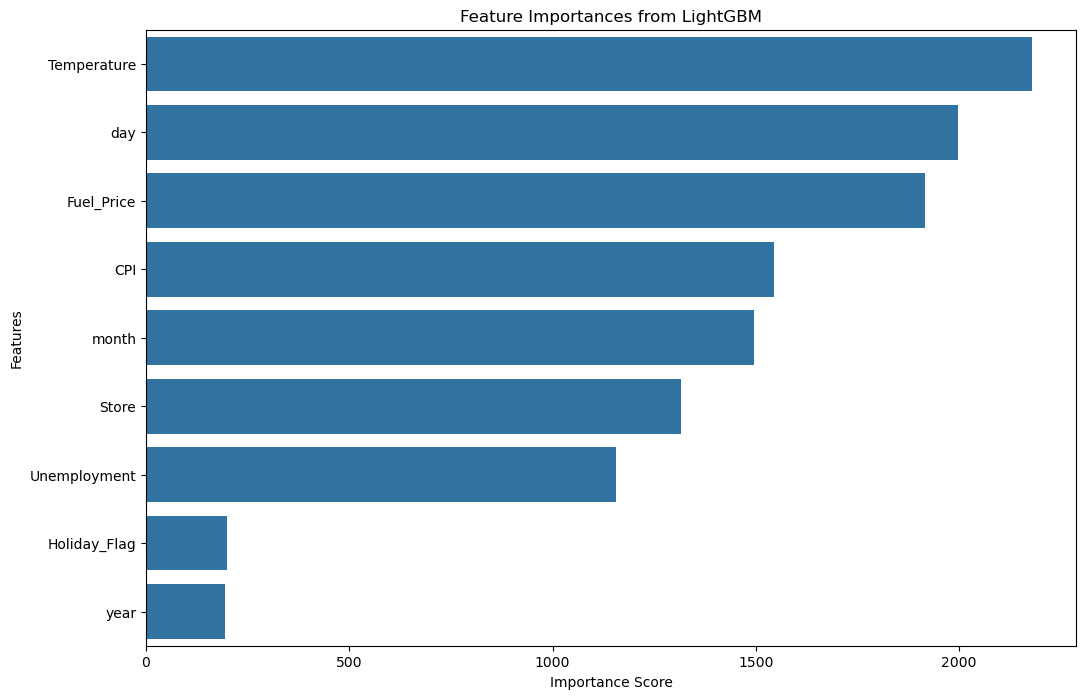

In [62]:
# plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances from LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

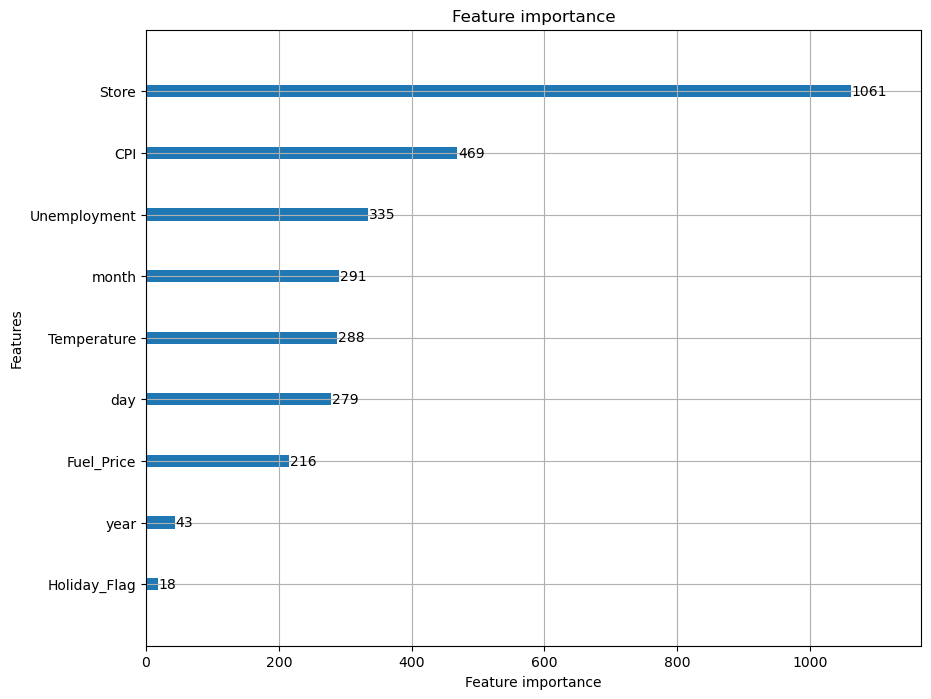

In [65]:
# Feature importance plot
lgb.plot_importance(model, importance_type='split', figsize=(10, 8))
plt.show()

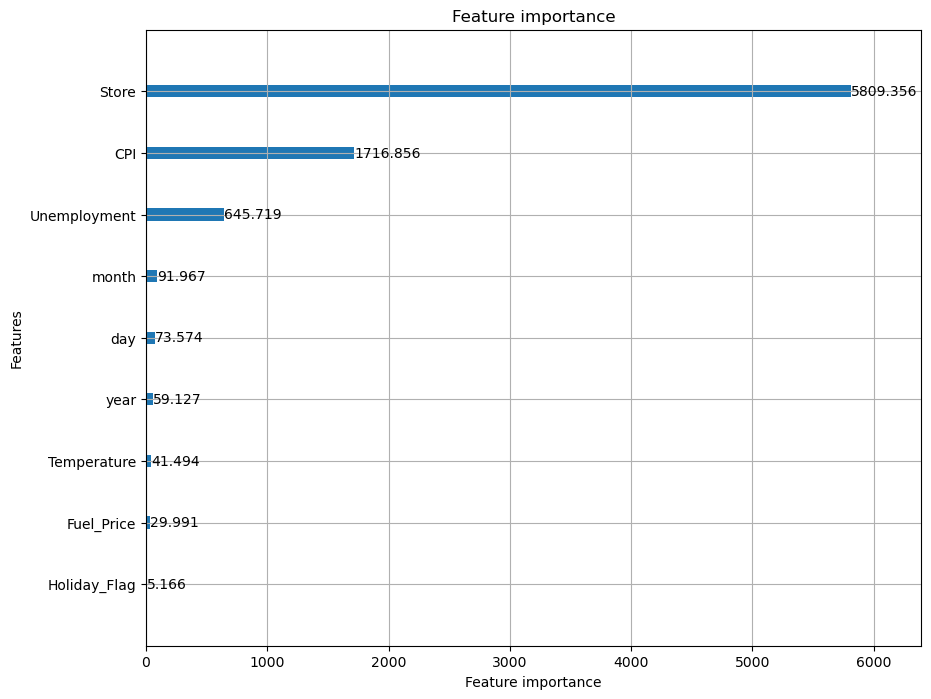

In [80]:
# Feature importance plot
lgb.plot_importance(model, importance_type='gain', figsize=(10, 8))
plt.show()

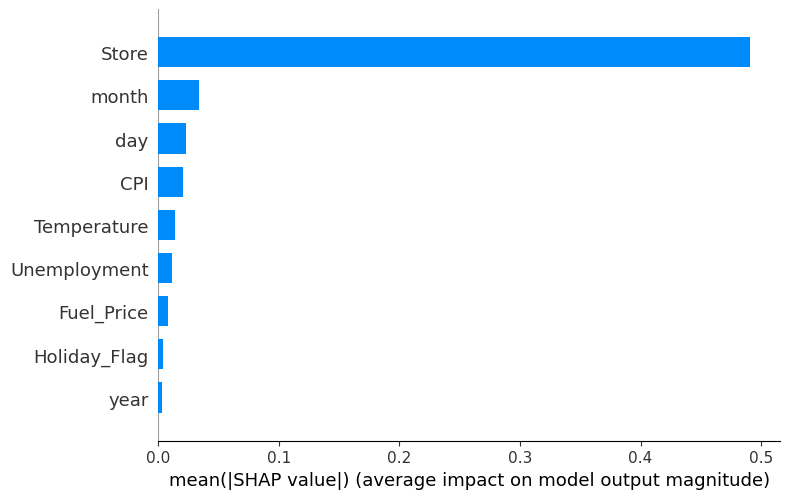

In [67]:
# Shap values calculation
import shap

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")




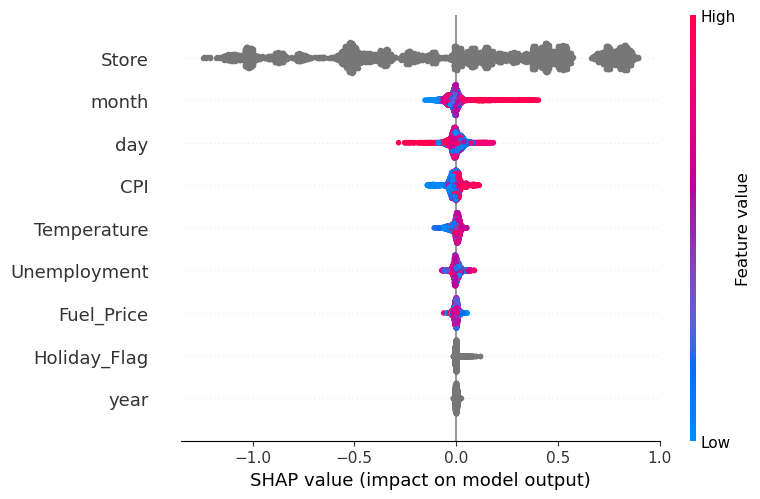

In [68]:
# Detailed summary plot (beeswarm)
shap.summary_plot(shap_values, X_train)

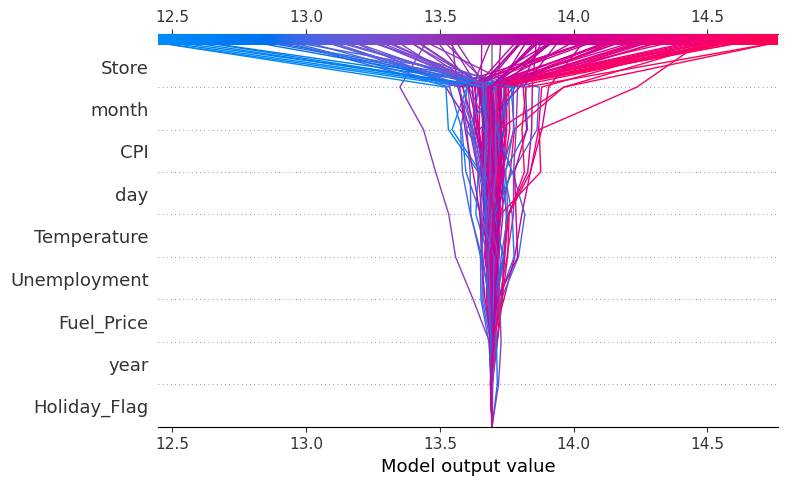

In [71]:
# Decision plot for first 10 samples
shap.decision_plot(explainer.expected_value, shap_values[:100], X_train.iloc[:100])

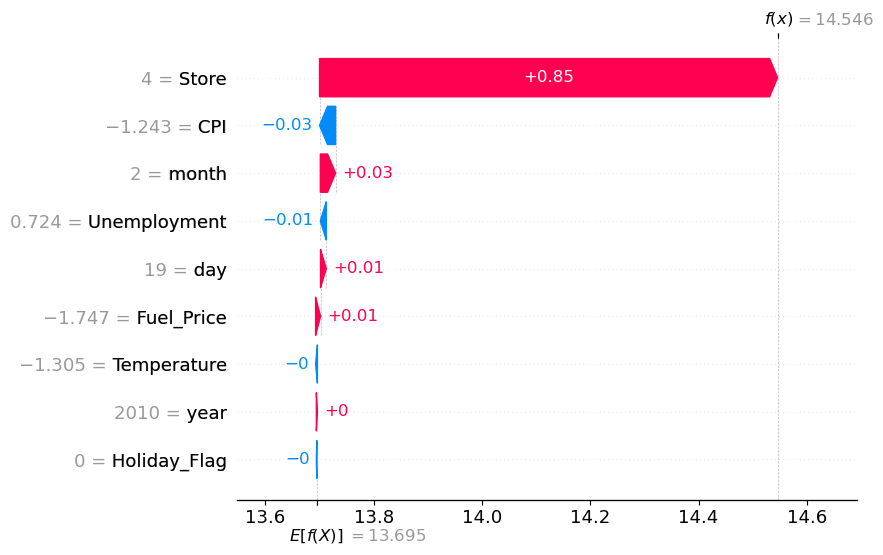

In [72]:
# Waterfall plot for a single prediction (requires shap.Explanation object)
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                      base_values=explainer.expected_value, 
                                      data=X_train.iloc[0], 
                                      feature_names=X_train.columns.tolist()))

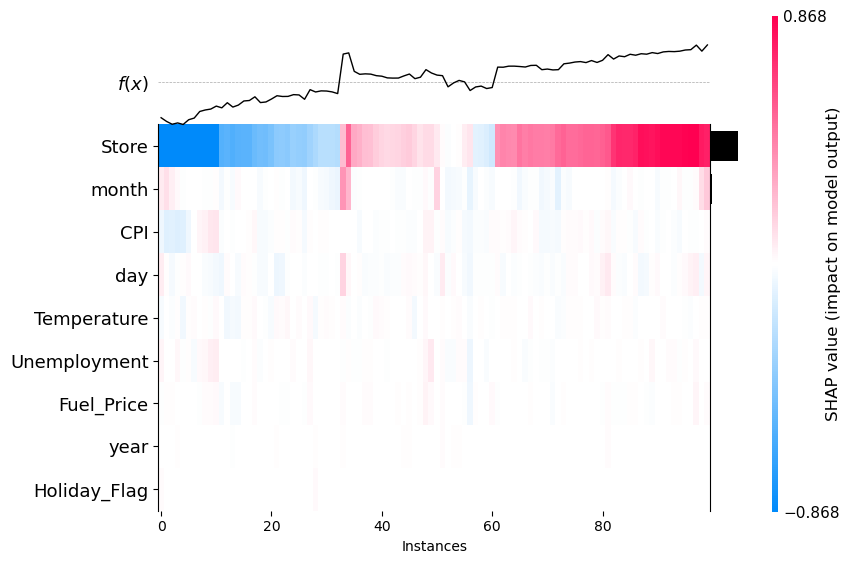

<Axes: xlabel='Instances'>

In [74]:
# Heatmap plot for first 100 samples (correct way)
shap_heatmap_exp = shap.Explanation(
    values=shap_values[:100],
    base_values=explainer.expected_value,
    data=X_train.iloc[:100],
    feature_names=X_train.columns.tolist()
)
shap.plots.heatmap(shap_heatmap_exp)

Summary:
1. Store is consistently identified as important feature for predicting weekly sales.
2. Other significant features include temperature, fuel price,CPI, unemployment and time based features such as month and day.
3. Both feature importances and shap plots says similar information which increases confidence in the model's interpretability and reliability.